In this workbook, we fit the processed raw data to Logistic Regression, Random Forests and Gradient Boosted Trees

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV
from sklearn.metrics import roc_curve, auc

In [3]:
import xgboost as xgb

In [4]:
from imblearn.over_sampling import SMOTE

### Import the data set

In [5]:
mooc_df = pd.read_feather('../data/processed-mooc-data.feather')

In [6]:
mooc_clean_df = pd.get_dummies(mooc_df)

features = np.array(mooc_clean_df.drop('engaged', axis=1))
labels = np.array(mooc_clean_df['engaged'])

features_train, features_test, labels_train, labels_test = train_test_split(features, labels,
                                                                            test_size=0.2,
                                                                            random_state=20130810)

### Helpers to fit and evaluate the model

In [7]:
def fit_model(features_train, labels_train, classifier_obj, param_grid, n_splits=10, n_repeats=3):
    
    """
    
    Takes in the data and a model object, fits the model using the model object 
    passed in and returns the results from the cross validation process.
    
    It also returns the test set split into features and labels
    
    """
    
    sm = SMOTE(random_state=20130810)
    
    features_train_smote, labels_train_smote = sm.fit_sample(features_train, labels_train)
    
    grid_search = GridSearchCV(classifier_obj, 
                               param_grid, 
                               cv = RepeatedKFold(n_splits,
                                                  n_repeats,
                                                  random_state=20130810),
                               verbose=1)
    
    grid_search.fit(features_train_smote, labels_train_smote)
    
    return grid_search

In [8]:
def evaluate(model_fit_grid, features_test, labels_test):
    
    preds = model_fit_grid.predict_proba(features_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(labels_test, preds)
    
    model_accuracy = model_fit_grid.best_score_
    
    model_auc = auc(fpr, tpr)
    
    return pd.DataFrame(dict(false_positive_rate=fpr, true_positive_rate=tpr)), model_accuracy, model_auc

### Fit and evaluate Logistic Regression

In [ ]:
model_logit = LogisticRegression(solver='lbfgs',
                                 n_jobs=-1, 
                                 random_state=20130810,
                                 warm_start=True)

In [ ]:
parameter_grid = { 'C' : [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4] } 

In [ ]:
logit_fit_grid = fit_model(features_train, labels_train, model_logit, parameter_grid)

In [ ]:
logit_roc_data, logit_accuracy, logit_auc = evaluate(logit_fit_grid, features_test, labels_test)

In [ ]:
logit_roc_data.to_feather('../data/logit-roc.feather')

In [ ]:
logit_roc_data.to_feather('../../../../../Google Drive/data-for-experimentation/logit-roc.feather')

### Fit and evaluate Random Forests

In [ ]:
model_rf = RandomForestClassifier(n_jobs=-1, 
                                  warm_start=True,
                                  random_state=20130810)

In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [200, 500, 1000]
}

In [ ]:
rf_fit_grid = fit_model(features_train, labels_train, model_rf, parameter_grid, n_splits=10, n_repeats=1)

In [ ]:
rf_roc_data, rf_accuracy, rf_auc = evaluate(rf_fit_grid, features_test, labels_test)

In [ ]:
rf_roc_data.to_feather('../data/rf-roc.feather')

In [ ]:
rf_roc_data.to_feather('../../../../../Google Drive/data-for-experimentation/rf-roc.feather')

### Fit and evaluate Gradient Boosted Trees

In [9]:
model_xgb = xgb.XGBClassifier(objective='reg:logistic')

In [10]:
param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [6, 10, 12]
}

In [11]:
xgb_fit_grid = fit_model(features_train, labels_train, model_xgb, param_grid, n_splits=10, n_repeats=1)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

In [12]:
xgb_roc_data, xgb_accuracy, xgb_auc = evaluate(xgb_fit_grid, features_test, labels_test)

In [13]:
xgb_roc_data.to_feather('../data/xgb-roc.feather')

In [14]:
xgb_roc_data.to_feather('../../../../../Google Drive/data-for-experimentation/xgb-roc.feather')

In [ ]:
pd.DataFrame({ 'acccuracy' : [logit_accuracy, rf_accuracy, xgb_accuracy] ,
               'auc' : [logit_auc, rf_auc, xgb_auc]})

In [22]:
xgb_fit_grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='reg:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid', {'grid_color' : '0.9'})
sns.set_context('talk', font_scale=1.2)
sns.set_palette('gray')

In [44]:
pd.DataFrame({ 'feature' : mooc_clean_df.columns[1:], 
               'feature_importance' : xgb_fit_grid.best_estimator_.feature_importances_}).to_feather('../data/xgb-feature-importance.feather')

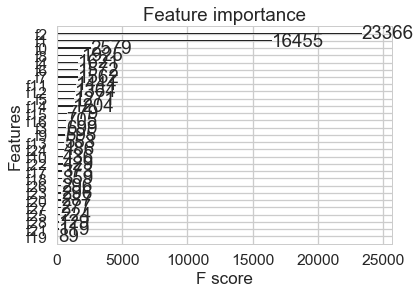

In [33]:
xgb.plot_importance(xgb_fit_grid.best_estimator_)

In [41]:
len(mooc_clean_df.columns[1:])

29

In [42]:
len(xgb_fit_grid.best_estimator_.feature_importances_)

29